# Scikit Classifiers for score comparison

## Load data:

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("C:/data"))

# Any results you write to the current directory are saved as output.
train = pd.read_csv('C:/data/train_out.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

['sample_submission.csv', 'submission.csv', 'test', 'train.csv']


## read 400M first rows (this is only necessary for Henrik):

In [17]:
#train = pd.read_csv('C:/data/train.csv', nrows=400_000_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
#train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [18]:
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [19]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [20]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


## Create a training file with simple derived features:

In [51]:
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min', 'kurt', 'skew', '25per', '50per', '75per','abs_max', 'abs_mean', 'abs_std'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'kurt'] = kurtosis(x)
    X_train.loc[segment, 'skew'] = skew(x)
    X_train.loc[segment, '25per'] = np.quantile(x,0.25)
    X_train.loc[segment, '50per'] = np.quantile(x,0.50)
    X_train.loc[segment, '75per'] = np.quantile(x,0.75)
    X_train.loc[segment, 'abs_max'] = np.abs(x).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x).std()

100%|██████████████████████████████████████████████████████████████████████████████| 2666/2666 [01:15<00:00, 40.34it/s]


In [52]:
X_train.head()

,ave,std,max,min,kurt,skew,25per,50per,75per,abs_max,abs_mean,abs_std
0,4.884113333333334,5.101089126891323,104.0,-98.0,33.661319221480703,-0.024060926015874,3.0,5.0,7.0,104.0,5.576566666666666,4.333310229553795
1,4.725766666666667,6.588801819164257,181.0,-154.0,98.755185259155695,0.390556598755942,2.0,5.0,7.0,181.0,5.734166666666667,5.732757856292980
2,4.906393333333333,6.967373808828945,140.0,-106.0,33.554052910588105,0.217388387534031,2.0,5.0,7.0,140.0,6.152646666666667,5.895925061301991
3,4.902240000000000,6.922282112791032,197.0,-199.0,116.544246785098039,0.757269963614698,2.0,5.0,7.0,199.0,5.933960000000000,6.061193396111583
4,4.908720000000000,7.301085852684289,145.0,-126.0,52.976098920993913,0.064530423958889,2.0,5.0,7.0,145.0,6.110586666666666,6.329464215541647


## Preprocess/normalize training data (mean = 0 and std = 1. Normalization is performed to get a more robust relationship between features when seeking for relations):

In [53]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

## Compute score using Linear Regression

In [54]:
linearRegressor = LinearRegression()
linearRegressor.fit(X_train_scaled, y_train.values.flatten())
y_pred = linearRegressor.predict(X_train_scaled)

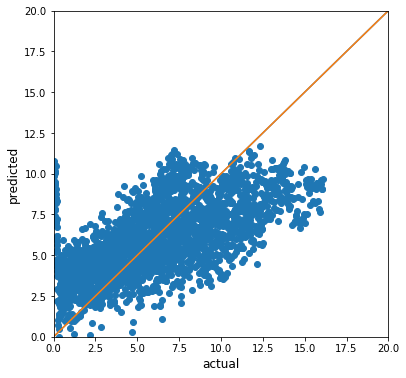

In [55]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [56]:
score = mean_absolute_error(y_train.values.flatten(), y_pred1)
print(f'Score: {score:0.3f}')

Score: 2.618


## Compute score using SVR

In [57]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

### points in the following plot should be along the sinister diagonal (bottom left-top right) where predicted=actual

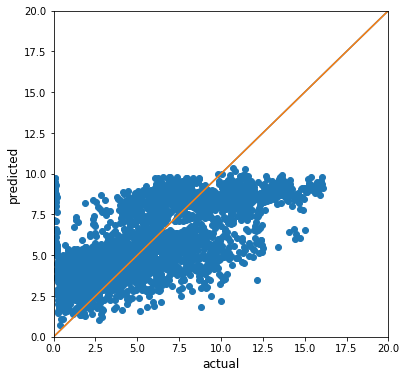

In [58]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [59]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.303


## Compute score using Gradient Boosting Regressor:

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(learning_rate=0.1,n_estimators=200,loss='ls').fit(X_train_scaled,y_train.values.flatten())
y_pred = model.predict(X_train_scaled)

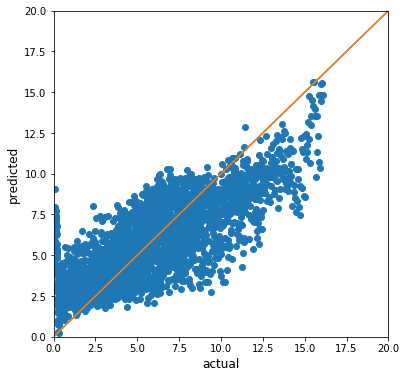

In [61]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [62]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 1.836


## Write to submission file

In [27]:
submission = pd.read_csv('C:/data/sample_submission.csv', index_col='seg_id')

In [28]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [29]:
for seg_id in X_test.index:
    seg = pd.read_csv('c:/data/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [30]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')